# Calibración de frecuencia

In [10]:
import threading
import time
import csv
import numpy as np
import sounddevice as sd
import serial
from ctypes import cast, POINTER
from comtypes import CLSCTX_ALL
from pycaw.pycaw import AudioUtilities, IAudioEndpointVolume
import matplotlib.pyplot as plt

In [2]:
SLM_COM_PORT = "COM22"
SLM_BAUDRATE = 115200
SLM_PERIOD = 0.125

In [3]:
# Frequencies taken from IEC 61672-1 and rounded to one decimal place
iec61672_freqs = (
    100.0, 125.9, 158.5, 199.5, 251.2, 316.2, 
    398.1, 501.2, 631.0, 794.3, 1000.0, 1258.9, 1584.9, 1995.3, # Up to 2 kHz at 1/3-octave
    2238.7, 2511.9, 2818.4, 3162.3, 3548.1, 3984.1, 4466.8, 5011.9, 5623.4, 6309.6, 
    7079.5, 7943.3, # 2 to 8 kHz at 1/6-octave
    8414.0, 8912.5, 9440.6, 10000.0, 10593.0, 11220.0, 11885.0, 12589.0, 13335.0, 14125.0,
    14962.0, 15849.0, 16788.0, 17783.0, 18836.0, 19953.0 # Up to 20 kHz at 1/12-octave
)

freq_response_waves = {
    "frequencies": iec61672_freqs,
    "volumes": (0.01, 0.02, 0.03, 0.04, 0.05, 0.06)
}

freq_sweep_waves = {
    "frequencies": (1000, 8000, 12000),
    "volumes": (0.01, 0.02, 0.03, 0.04, 0.05, 0.06)
}

freq_weighting_waves = {
    "frequencies": iec61672_freqs,
    "volumes": (0.01, 0.02, 0.03, 0.04, 0.05, 0.06)
}

In [4]:
# Get the default audio playback device
devices = AudioUtilities.GetSpeakers()
interface = devices.Activate(
    IAudioEndpointVolume._iid_, CLSCTX_ALL, None)

# Create a volume control interface
volume_controller = cast(interface, POINTER(IAudioEndpointVolume))

In [16]:
# Variables for status syncronization between threads
current_freq = 0
current_volume = 0.0

In [23]:
# Format the data container for the specified test waves
def format_data(data, test_waves):
    for freq in test_waves["frequencies"]:
        data[freq] = {}

        for volume in test_waves["volumes"]:
            data[freq][volume] = []

# Function to receive serial data and store it
def receive_serial_data(data):
    ser = serial.Serial(SLM_COM_PORT, SLM_BAUDRATE)  # Replace 'COM1' with your serial port
    while not terminate_event.is_set():
        received_data = ser.readline().decode().strip()
        received_data = received_data.split(" ")[0]
        try:
            received_data = float(received_data)
        except ValueError:
            received_data = float(received_data.split(".")[0])
        try:
            if log_flag: 
                data[current_freq][current_volume].append(received_data)
        except KeyError:
            pass
    ser.close()

# Function to play audio sine waves
def play_test_waves(test_waves):
    duration = 2.5 if SLM_PERIOD == 0.125 else 20
    sample_rate = 88200
    t = np.arange(0, duration, 1 / sample_rate)

    for freq in test_waves["frequencies"]:
        current_freq = freq
        sine_wave = np.sin(2 * np.pi * freq * t)

        for volume in test_waves["volumes"]:
            current_volume = volume
            log_flag = True

            volume_controller.SetMasterVolumeLevelScalar(volume, None)

            # Wait before playing the sine wave
            time.sleep(0.5 if SLM_PERIOD == 0.125 else 3) #s

            sd.play(sine_wave, sample_rate, blocking=True)

            # Wait after playback is done
            time.sleep(0.5 if SLM_PERIOD == 0.125 else 3) #s
        
        log_flag = False

    # Send a signal to the other thread to terminate
    terminate_event.set()

In [6]:
def play_sync_impulses():
    # Duration of the impulse in seconds
    duration = 0.09 if SLM_PERIOD == 0.125 else 0.9 # s
    sample_rate = 88200
    t = np.arange(0, duration, 1 / sample_rate)

    # Create an impulse signal
    impulse = np.sin(2 * np.pi * 1000 * t)

    # Wait before playing the impulse
    time.sleep(0.5 if SLM_PERIOD == 0.125 else 3) #s

    # Play the impulse
    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.3 if SLM_PERIOD == 0.125 else 2)

    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.6 if SLM_PERIOD == 0.125 else 4)

    sd.play(impulse, sample_rate, blocking=True)

    time.sleep(0.5 if SLM_PERIOD == 0.125 else 3)

In [24]:
# Create containers to store received serial data
freq_response_data = {}
freq_sweep_data = {}
freq_weighting_data = {}

# Format the containers
format_data(freq_response_data, freq_response_waves)
format_data(freq_sweep_data, freq_sweep_waves)
format_data(freq_weighting_data, freq_weighting_waves)

# Event to signal termination
terminate_event = threading.Event()
# Flag to signal when to log measurements
log_flag = False

## Ejecutar pruebas

In [ ]:
# *** Frequency response ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_response_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_response_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play sync impulses
play_sync_impulses()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

In [26]:
# *** Frequency sweep ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_sweep_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_sweep_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play sync impulses
play_sync_impulses()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

In [27]:
print(freq_sweep_data)

{1000: {0.01: [], 0.02: [], 0.03: [], 0.04: [], 0.05: [], 0.06: []}, 8000: {0.01: [], 0.02: [], 0.03: [], 0.04: [], 0.05: [], 0.06: []}, 12000: {0.01: [], 0.02: [], 0.03: [], 0.04: [], 0.05: [], 0.06: []}}


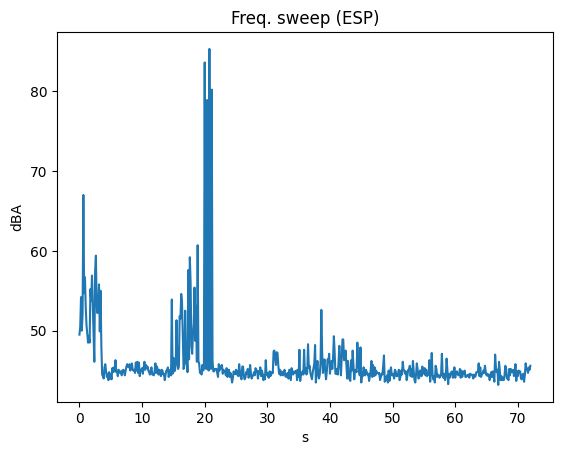

In [13]:
# Create x-axis values
x_axis = [x * SLM_PERIOD for x in range(len(freq_sweep_data))]

# Create a plot
plt.plot(x_axis, freq_sweep_data)

# Add labels and a title (optional)
plt.xlabel("s")
plt.ylabel("dBA")
plt.title("Freq. sweep (ESP)")

# Show the plot
plt.show()

In [ ]:
# *** Frequency weighting ***

# Create the serial data receiving thread
serial_thread = threading.Thread(target=receive_serial_data, args=(freq_weighting_data,))
serial_thread.daemon = True

# Create the audio playback thread
audio_thread = threading.Thread(target=play_test_waves, args=(freq_weighting_waves,))
audio_thread.daemon = True

# Start serial thread
serial_thread.start()
# Play sync impulses
play_sync_impulses()
# Play tests
audio_thread.start()

# Wait for the threads to finish
serial_thread.join()
audio_thread.join()

# Reset the event for next test
terminate_event.clear()

## Analizar datos